In [ ]:
import json
import folium
from datetime import datetime
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def parse_timestamp(ts_str):
    """解析时间字符串为 datetime 对象。如果不包含时区，则假设为 UTC 并补充 '+00:00'。"""
    if ts_str is None:
        return None
    # 如果没有时区信息，自动补充
    if not (ts_str.endswith("Z") or ('+' in ts_str[-6:] or '-' in ts_str[-6:])):
        ts_str += "+00:00"
    try:
        return datetime.fromisoformat(ts_str)
    except Exception:
        try:
            return datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S")
        except Exception:
            return None

def get_color_for_error(error, min_error, max_error):
    """
    根据误差值计算颜色。定义自定义颜色序列：红、橙、黄、绿、青、蓝、紫，
    且 0 对应绿，负数越大（负值较小）颜色越偏红，正数越大颜色越偏紫。
    """
    # 自定义颜色序列
    custom_colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple']
    custom_cmap = LinearSegmentedColormap.from_list("custom_rainbow", custom_colors)

    # 使用对称归一化：以 0 为中心
    max_abs = max(abs(min_error), abs(max_error))
    if max_abs == 0:
        norm_value = 0.5
    else:
        norm_value = 0.5 + 0.5 * (error / max_abs)
        norm_value = max(0, min(1, norm_value))
    rgba = custom_cmap(norm_value)
    hex_color = mcolors.rgb2hex(rgba)
    return hex_color

# 文件路径：转换后的 JSON 文件（内容为 JSON 数组）
data_path = "0_4.jsonl"

# 读取 JSON 文件内容
with open(data_path, 'r', encoding='utf-8') as f:
    voyages = json.load(f)

if not isinstance(voyages, list) or len(voyages) == 0:
    raise ValueError("文件中没有找到有效的航班数据。")

# 为所有航班计算总体中心位置
all_lats = []
all_lons = []
for voyage in voyages:
    for pt in voyage.get("Path", []):
        if "latitude" in pt and "longitude" in pt:
            all_lats.append(pt["latitude"])
            all_lons.append(pt["longitude"])
if all_lats and all_lons:
    center = [sum(all_lats)/len(all_lats), sum(all_lons)/len(all_lons)]
else:
    center = [0, 0]

# 创建基础地图
m = folium.Map(location=center, zoom_start=4)

# 定义一组颜色用于航迹折线（每个航班一个颜色）
line_colors = ["blue", "green", "orange", "darkred", "cadetblue",
               "darkgreen", "lightblue", "pink", "gray", "black"]

# 遍历所有航班绘制航迹与路径点
for idx, voyage in enumerate(voyages):
    if idx > 50:
        break
    path_points = voyage.get("Path", [])
    # 提取有效坐标
    coords = [(pt["latitude"], pt["longitude"]) for pt in path_points
              if "latitude" in pt and "longitude" in pt]
    if not coords:
        continue

    line_color = line_colors[idx % len(line_colors)]
    folium.PolyLine(coords, color=line_color, weight=2.5, opacity=1,
                    popup=f"航班 {idx+1}").add_to(m)
    folium.Marker(coords[0], popup=f"航班 {idx+1} 起点", icon=folium.Icon(color=line_color)).add_to(m)
    folium.Marker(coords[-1], popup=f"航班 {idx+1} 终点", icon=folium.Icon(color=line_color)).add_to(m)

    # 计算当前航班最后一个路径点的时间戳
    if "timestamp" in path_points[-1]:
        final_ts = parse_timestamp(path_points[-1]["timestamp"])
    else:
        final_ts = None

    # 预先计算所有点的误差 (eta - final_ts)，单位：小时
    errors = []
    for pt in path_points:
        if "eta" in pt and final_ts is not None:
            eta_ts = parse_timestamp(pt.get("eta"))
            if eta_ts is not None:
                err = (eta_ts - final_ts).total_seconds() / 3600.0
                errors.append(err)
    if errors:
        min_error = min(errors)
        max_error = max(errors)
    else:
        min_error, max_error = -1, 1

    # 对每个路径点添加圆形标记，显示详细信息，并根据误差动态设定颜色
    for pt in path_points:
        if "latitude" in pt and "longitude" in pt:
            lat = pt["latitude"]
            lon = pt["longitude"]
            timestamp = pt.get("timestamp", "N/A")
            speed = pt.get("speed", "N/A")
            eta = pt.get("eta", "N/A")
            error_val = None
            if "eta" in pt and final_ts is not None:
                eta_ts = parse_timestamp(pt.get("eta"))
                if eta_ts:
                    error_val = (eta_ts - final_ts).total_seconds() / 3600.0
            if error_val is None:
                error_val = 0.0
            error_text = f"{error_val:.2f} 小时"
            marker_color = get_color_for_error(error_val, min_error, max_error)
            popup_text = (f"时间: {timestamp}\n"
                          f"速度: {speed}\n"
                          f"ETA: {eta}\n"
                          f"误差(ETA-最后节点): {error_text}")
            folium.CircleMarker(
                location=[lat, lon],
                radius=4,
                color=marker_color,
                fill=True,
                fill_color=marker_color,
                popup=popup_text
            ).add_to(m)
output_html = "voyage_path.html"
m.save(output_html)
print(f"地图已保存为 {output_html}")
m


In [ ]:
import json
import glob
import os
import logging

# —— 配置 —— #
data_dir    = ""   # 数据目录
pattern     = os.path.join(data_dir, "*.jsonl")
target_mmsi = 205784000                              # 要查询的船 MMSI

# —— 日志设置 —— #
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger("voyage_counter")

# —— 统计变量 —— #
total_count = 0
files = sorted(glob.glob(pattern))
if not files:
    logger.error("未在目录 %s 下找到任何 .jsonl 文件。", data_dir)
    raise SystemExit(1)

logger.info("开始遍历 %d 个文件，目标 MMSI=%s", len(files), target_mmsi)

for file_path in files:
    logger.info("正在处理文件：%s", os.path.basename(file_path))
    per_file_count = 0

    # 尝试将整个文件当 JSON 数组解析
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            voyages = json.load(f)
        logger.debug("  成功以 JSON 数组格式加载，共 %d 条记录。", len(voyages))
    except json.JSONDecodeError:
        # 回退到逐行解析 jsonl
        logger.warning("  文件不是纯 JSON 数组，回退到逐行解析。")
        voyages = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for lineno, line in enumerate(f, start=1):
                line = line.strip()
                if not line:
                    continue
                try:
                    voyages.append(json.loads(line))
                except json.JSONDecodeError:
                    logger.error("    第 %d 行 JSON 解析失败，内容：%s", lineno, line[:50])
        logger.info("  逐行解析完成，共收集 %d 条记录。", len(voyages))

    # 验证记录格式、并统计目标 MMSI 出现次数
    for idx, voyage in enumerate(voyages, start=1):
        mmsi = voyage.get("MMSI")
        if mmsi is None:
            logger.warning("    第 %d 条记录缺少 MMSI 字段，跳过。", idx)
            continue
        if mmsi == target_mmsi:
            per_file_count += 1

    logger.info("  在该文件中出现了 %d 次。", per_file_count)
    total_count += per_file_count

# —— 输出最终结果 —— #
logger.info("统计完成。MMSI=%s 的船在所有文件中共出现 %d 次航程记录。",
            target_mmsi, total_count)



In [ ]:
import json
import glob
import os
import logging

# —— 配置 —— #
data_dir    = ""   # 数据目录
pattern     = os.path.join(data_dir, "*.jsonl")
target_port = "Puerto Quetzal"                        # 要查询的港口名称

# —— 日志设置 —— #
logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger("port_counter")

# —— 统计变量 —— #
total_count = 0
files = sorted(glob.glob(pattern))
if not files:
    logger.error("未在目录 %s 下找到任何 .jsonl 文件。", data_dir)
    raise SystemExit(1)

logger.info("开始遍历 %d 个文件，目标港口：%s", len(files), target_port)

for file_path in files:
    logger.info("处理文件：%s", os.path.basename(file_path))
    per_file_count = 0

    # 先尝试将整个文件当作 JSON 数组加载
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            voyages = json.load(f)
        logger.debug("  以 JSON 数组格式加载，共 %d 条记录。", len(voyages))
    except json.JSONDecodeError:
        # 回退到逐行解析
        logger.warning("  文件不是纯 JSON 数组，回退到逐行解析 jsonl。")
        voyages = []
        with open(file_path, 'r', encoding='utf-8') as f:
            for lineno, line in enumerate(f, start=1):
                line = line.strip()
                if not line:
                    continue
                try:
                    voyages.append(json.loads(line))
                except json.JSONDecodeError:
                    logger.error("    第 %d 行解析失败，内容前50字符：%s", lineno, line[:50])
        logger.info("  逐行解析完成，共 %d 条记录。", len(voyages))

    # 遍历记录，检查 Start Port 或 End Port
    for idx, voyage in enumerate(voyages, start=1):
        # 检查 Start Port
        sp = voyage.get("Start Port")
        if isinstance(sp, dict):
            name = sp.get("Main Port Name")
            if name == target_port:
                per_file_count += 1
        else:
            logger.debug("    记录 %d 的 Start Port 字段缺失或格式不对。", idx)

        # 检查 End Port
        ep = voyage.get("End Port")
        if isinstance(ep, dict):
            name = ep.get("Main Port Name")
            if name == target_port:
                per_file_count += 1
        else:
            logger.debug("    记录 %d 的 End Port 字段缺失或格式不对。", idx)

    logger.info("  在该文件中共匹配到 %d 次。", per_file_count)
    total_count += per_file_count

logger.info("统计完成。港口 [%s] 共出现 %d 次。", target_port, total_count)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
import_and_split_fresh.py

功能：
 1. 连接到 eta_voyage1 数据库
 2. DROP 旧表 voyage_node, voyage_main（如果有）
 3. CREATE EXTENSION postgis
 4. 新建 voyage_main, voyage_node（含 train 列）
 5. 遍历当前目录下所有 *.jsonl 文件，批量插入 voyage_main 和 voyage_node
    • voyage_main 插入时随机 5% 标为 valid=False，其余 train=True
    • voyage_node 继承对应 voyage_main 的 train 标记
    • 插入后更新 geom
 6. tqdm 显示每个文件导入的进度和记录数
"""

import os
import json
import random
import psycopg2
from psycopg2.extras import execute_values
from tqdm import tqdm

# ========== 配置 ==========
DB_PARAMS = {
    'dbname':   'eta_voyage1',
    'user':     'postgres',
    'password': 'y1=x2-c30',
    'host':     'localhost',
    'port':     5432
}
DATA_DIR    = '..'  # 与脚本同目录下的 *.jsonl
MAIN_BATCH  = 200        # 主表每批插入大小
NODE_BATCH  = 5000       # 节点表每批插入大小
VALID_RATIO = 0.05       # 5% 划为验证集 (train=False)

# ========== DDL ==========

DDL_DROP = """
DROP TABLE IF EXISTS voyage_node;
DROP TABLE IF EXISTS voyage_main;
"""

DDL_CREATE = """
CREATE EXTENSION IF NOT EXISTS postgis;

CREATE TABLE voyage_main (
  id                 SERIAL PRIMARY KEY,
  mmsi               BIGINT       NOT NULL,
  imo                DOUBLE PRECISION,
  call_sign          TEXT,
  name               TEXT,
  type               DOUBLE PRECISION,
  width              DOUBLE PRECISION,
  length             DOUBLE PRECISION,
  flag               TEXT,
  destination        TEXT,
  start_time         TIMESTAMP,
  end_time           TIMESTAMP,
  start_lat          DOUBLE PRECISION,
  start_lon          DOUBLE PRECISION,
  end_lat            DOUBLE PRECISION,
  end_lon            DOUBLE PRECISION,
  path_len           INTEGER,
  start_port_lat     DOUBLE PRECISION,
  start_port_lon     DOUBLE PRECISION,
  start_port_name    TEXT,
  start_port_country TEXT,
  start_port_wpi     INTEGER,
  end_port_lat       DOUBLE PRECISION,
  end_port_lon       DOUBLE PRECISION,
  end_port_name      TEXT,
  end_port_country   TEXT,
  end_port_wpi       INTEGER,
  train              BOOLEAN NOT NULL DEFAULT TRUE
);

CREATE TABLE voyage_node (
  id            SERIAL PRIMARY KEY,
  voyage_id     INTEGER NOT NULL REFERENCES voyage_main(id) ON DELETE CASCADE,
  timestamp     TIMESTAMP,
  latitude      DOUBLE PRECISION,
  longitude     DOUBLE PRECISION,
  geom          GEOMETRY(Point,4326),
  speed         DOUBLE PRECISION,
  heading       DOUBLE PRECISION,
  course        DOUBLE PRECISION,
  draught       DOUBLE PRECISION,
  rot           DOUBLE PRECISION,
  eta           TIMESTAMP WITH TIME ZONE,
  status        DOUBLE PRECISION,
  train         BOOLEAN NOT NULL DEFAULT TRUE
);

CREATE INDEX idx_voyage_node_geom ON voyage_node USING GIST (geom);
"""

SQL_INSERT_MAIN = """
INSERT INTO voyage_main (
  mmsi, imo, call_sign, name, type, width, length, flag, destination,
  start_time, end_time, start_lat, start_lon, end_lat, end_lon,
  path_len, start_port_lat, start_port_lon, start_port_name,
  start_port_country, start_port_wpi, end_port_lat, end_port_lon,
  end_port_name, end_port_country, end_port_wpi, train
) VALUES %s
RETURNING id, train;
"""

SQL_INSERT_NODE = """
INSERT INTO voyage_node (
  voyage_id, timestamp, latitude, longitude,
  speed, heading, course, draught, rot, eta, status, train
) VALUES %s;
"""

SQL_UPDATE_GEOM = """
UPDATE voyage_node
   SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)
 WHERE geom IS NULL;
"""

# ========== 辅助函数 ==========

def list_jsonl_files(data_dir):
    files = [f for f in os.listdir(data_dir) if f.endswith('.jsonl')]
    files.sort(key=lambda f: int(f.split('_')[0]))
    return [os.path.join(data_dir, f) for f in files]

# ========== 主流程 ==========

def import_and_split_fresh():
    conn = psycopg2.connect(**DB_PARAMS)
    cur  = conn.cursor()

    # 1) DROP + CREATE
    cur.execute(DDL_DROP)
    cur.execute(DDL_CREATE)
    conn.commit()

    # 2) 遍历并导入
    files = list_jsonl_files(DATA_DIR)
    for fp in tqdm(files, desc="Importing"):
        with open(fp, 'r', encoding='utf-8') as f:
            voyages = json.load(f)

        # a) 准备 voyage_main 数据，附带 train 列
        main_rows = []
        for v in voyages:
            is_train = random.random() > VALID_RATIO
            main_rows.append((
                v['MMSI'], v.get('IMO'), v.get('Call Sign'), v.get('Name'),
                v.get('Type'), v.get('Width'), v.get('Length'), v.get('Flag'),
                v.get('Destination'),
                v.get('Start Time'), v.get('End Time'),
                v.get('Start Lat'), v.get('Start Lon'),
                v.get('End Lat'), v.get('End Lon'),
                v.get('Path Len'),
                v['Start Port']['Latitude'], v['Start Port']['Longitude'],
                v['Start Port']['Main Port Name'], v['Start Port']['Country Code'],
                v['Start Port']['World Port Index Number'],
                v['End Port']['Latitude'], v['End Port']['Longitude'],
                v['End Port']['Main Port Name'], v['End Port']['Country Code'],
                v['End Port']['World Port Index Number'],
                is_train
            ))

        # b) 插入主表并收集 (id,train)
        id_train_list = []
        for i in range(0, len(main_rows), MAIN_BATCH):
            batch = main_rows[i:i+MAIN_BATCH]
            execute_values(cur, SQL_INSERT_MAIN, batch)
            id_train_list += cur.fetchall()
        conn.commit()

        # c) 准备并插入 voyage_node
        node_rows = []
        for (vid, vid_train), v in zip(id_train_list, voyages):
            for pt in v.get('Path', []):
                node_rows.append((
                    vid,
                    pt.get('timestamp'),
                    pt.get('latitude'),
                    pt.get('longitude'),
                    pt.get('speed'),
                    pt.get('heading'),
                    pt.get('course'),
                    pt.get('draught'),
                    pt.get('rot'),
                    pt.get('eta'),
                    pt.get('status'),
                    vid_train
                ))
        for j in range(0, len(node_rows), NODE_BATCH):
            batch = node_rows[j:j+NODE_BATCH]
            execute_values(cur, SQL_INSERT_NODE, batch)
        conn.commit()

        # d) 更新空间字段
        cur.execute(SQL_UPDATE_GEOM)
        conn.commit()

        tqdm.write(f"{os.path.basename(fp)} imported: "
                   f"{len(main_rows)} voyages, {len(node_rows)} nodes")

    cur.close()
    conn.close()
    print("✅ All done: fresh tables created, data imported, train/valid split applied.")

if __name__ == '__main__':
    import_and_split_fresh()


In [ ]:
SQL="""CREATE INDEX idx_voyage_node_vid_ts
    ON voyage_node (voyage_id, timestamp);

CLUSTER voyage_node USING idx_voyage_node_vid_ts;"""
conn = psycopg2.connect(**DB_PARAMS)
cur  = conn.cursor()

    # 1) DROP + CREATE
cur.execute(SQL)
conn.commit()
cur.close()
conn.close()

随机节点 ID: 14375101, 所属航次 ID: 44430, 坐标: (12.0759, 46.6639), 时间: 2021-03-06 09:40:00
该船舶在 train=True 且结束时间早于该节点时间的航次数: 3


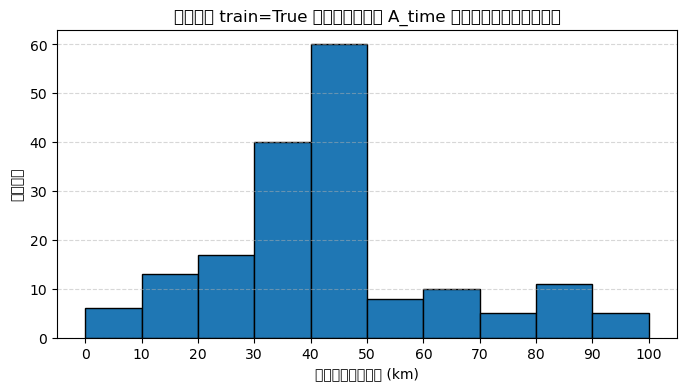

In [4]:
import psycopg2
import psycopg2.extras
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# 1. 连接数据库（请替换为你的实际连接参数）
conn = psycopg2.connect(
    dbname="eta_voyage1",
    user="postgres",
    password="y1=x2-c30",
    host="localhost",
    port=5432
)
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

# 2. 随机选取一个节点，并获取其时间
cur.execute("""
    SELECT id, voyage_id, latitude, longitude, timestamp
      FROM voyage_node
  ORDER BY RANDOM()
     LIMIT 1;
""")
node = cur.fetchone()
node_id, voyage_id, lat, lon, ts = node
print(f"随机节点 ID: {node_id}, 所属航次 ID: {voyage_id}, 坐标: ({lat:.4f}, {lon:.4f}), 时间: {ts}")

# 转为 Python datetime
if isinstance(ts, str):
    A_time = datetime.fromisoformat(ts)
else:
    A_time = ts

# 3. 统计该节点所属船舶在 train=True 且结束时间早于 A_time 的航次数量
cur.execute("""
    SELECT COUNT(*)
      FROM voyage_main
     WHERE train = TRUE
       AND mmsi = (
           SELECT mmsi
             FROM voyage_main
            WHERE id = %s
       )
       AND end_time < %s;
""", (voyage_id, A_time))
count_past = cur.fetchone()[0]
print(f"该船舶在 train=True 且结束时间早于该节点时间的航次数: {count_past}")

# 4. 查找所有其他 train=True 航次在 A_time 之前的最近节点及距离
cur.execute("""
WITH ref AS (
    SELECT ST_SetSRID(ST_MakePoint(%s, %s), 4326) AS p
)
SELECT DISTINCT ON (n.voyage_id)
       n.voyage_id,
       n.timestamp,
       ST_Distance(n.geom::geography, r.p::geography) AS dist_m
  FROM voyage_node n
  JOIN ref r ON true
  JOIN voyage_main m ON n.voyage_id = m.id
 WHERE m.train = TRUE
   AND n.voyage_id <> %s
   AND n.timestamp < %s
 ORDER BY n.voyage_id, dist_m;
""", (lon, lat, voyage_id, A_time))
rows = cur.fetchall()
distances_km = np.array([row['dist_m'] for row in rows]) / 1000.0

# 5. 绘制距离分布直方图（10km 为一个区间）
bins = np.arange(0, 101, 10)  # 0-10,10-20,... km
hist, bin_edges = np.histogram(distances_km, bins=bins)

plt.figure(figsize=(8, 4))
plt.bar(bin_edges[:-1], hist, width=10, edgecolor='black', align='edge')
plt.xlabel('最近节点距离区间 (km)')
plt.ylabel('航次数量')
plt.title('所有其他 train=True 且节点时间早于 A_time 的航次最近节点距离分布')
plt.xticks(bin_edges)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 6. 收尾
cur.close()
conn.close()


In [27]:
import psycopg2
import numpy as np
import folium
from scipy.interpolate import CubicHermiteSpline

DB_PARAMS = {
    'dbname':   'eta_voyage1',
    'user':     'postgres',
    'password': 'y1=x2-c30',
    'host':     'localhost',
    'port':     5432
}

def plot_hermite_exact_direction(output="hermite_dir_exact.html", arrow_len_m=5000):
    # 1) 随机取一条至少 3 点的航次
    with psycopg2.connect(**DB_PARAMS) as conn:
        cur = conn.cursor()
        cur.execute("""
          SELECT voyage_id FROM (
            SELECT voyage_id, COUNT(*) AS cnt
              FROM voyage_node GROUP BY voyage_id
            HAVING COUNT(*)>=3
          ) t ORDER BY random() LIMIT 1
        """)
        (vid,) = cur.fetchone()
        cur.execute("""
          SELECT latitude, longitude, course
            FROM voyage_node
           WHERE voyage_id=%s
           ORDER BY timestamp
        """,(vid,))
        rows = cur.fetchall()

    lats = np.array([r[0] for r in rows])
    lons = np.array([r[1] for r in rows])
    courses = np.array([r[2] for r in rows])

    # 2) 投影到局部平面（单位：米）
    R = 6371000.0
    lat0 = np.deg2rad(lats[0]); lon0 = np.deg2rad(lons[0])
    latr = np.deg2rad(lats);   lonr = np.deg2rad(lons)
    X = R * (lonr - lon0) * np.cos(lat0)
    Y = R * (latr - lat0)

    # 3) 参数 t 取为累计平面距离
    t = np.zeros_like(X)
    t[1:] = np.cumsum(np.hypot(np.diff(X), np.diff(Y)))

    # 4) 去重，保证 t 严格递增
    mask = np.concatenate(([True], np.diff(t) > 0))
    t2       = t[mask]
    X2, Y2   = X[mask], Y[mask]
    crs2     = courses[mask]
    if len(t2) < 3:
        raise RuntimeError("节点太少，无法插值")

    # 5) 切向量直接用航向 (0°=北,顺时针)
    theta = np.deg2rad(crs2)
    dX2   = np.sin(theta)  # 东西分量
    dY2   = np.cos(theta)  # 南北分量

    # 6) 构造 Hermite 样条
    sx = CubicHermiteSpline(t2, X2, dX2)
    sy = CubicHermiteSpline(t2, Y2, dY2)

    # 7) 采样并反投影回经纬度
    ts = np.unique(np.concatenate([t2, np.linspace(t2[0], t2[-1], 300)]))
    Xs = sx(ts);  Ys = sy(ts)
    lat_s = Ys / R * 180/np.pi + lats[0]
    lon_s = Xs / (R*np.cos(lat0)) * 180/np.pi + lons[0]

    # 8) 画 Folium 地图
    m = folium.Map(location=[lats.mean(), lons.mean()],
                   zoom_start=6, tiles="CartoDB positron")

    # 原始路径
    folium.PolyLine(list(zip(lats, lons)), color="gray", weight=2).add_to(m)

    # 原始节点 + 箭头方向
    lat_offset = arrow_len_m/R*180/np.pi
    for lat, lon, crs in zip(lats, lons, courses):
        folium.CircleMarker(location=[lat, lon],
                            radius=4, color="blue", fill=True).add_to(m)
        th = np.deg2rad(crs)
        dx = np.sin(th); dy = np.cos(th)
        end_lat = lat + dy*lat_offset
        end_lon = lon + dx*(lat_offset/np.cos(np.deg2rad(lat)))
        folium.PolyLine([[lat, lon], [end_lat, end_lon]],
                        color="blue", weight=2).add_to(m)

    # Hermite 插值曲线
    folium.PolyLine(list(zip(lat_s, lon_s)), color="red", weight=3).add_to(m)

    m.save(output)
    print("已保存交互式地图到", output)


if __name__ == "__main__":
    plot_hermite_exact_direction()


已保存交互式地图到 hermite_dir_exact.html
